Mass-Spring-Damper Model Estimation
-----------------------------------

### System Description

This is a really simple model: A 1-DOF mass-spring-damper system.

In [64]:
from IPython.display import Image

Image(url='https://github.com/stuckeyr/msd/raw/master/mass_spring_damper.png')

The equations of motion are:

$$
\sum F_x = F(t) - b \dot{x} - kx = m \ddot{x}
$$

Express the system in state-space. The state vector is:

$$
\mathbf{x} = \begin{bmatrix} x \\\ \dot{x} \end{bmatrix}
$$

And the equations are written:

$$
m \mathbf{\dot{x}} = \begin{bmatrix} \dot{x} \\\ \ddot{x} \end{bmatrix} = \begin{bmatrix} 0 & m \\\ -k & -b \end{bmatrix} \begin{bmatrix} x \\\ \dot{x} \end{bmatrix} + \begin{bmatrix} 0 \\\ 1 \end{bmatrix} F(t)
$$

### Simulation in Python 

In order to run the following, you'll need NumPy, SciPy and my msd.py library.

Reset the workspace. Import relevant functions.

In [65]:
%reset -f

In [66]:
from msd import MSD, plot, addplot
import sys
import numpy as np
import numpy.matlib as ml
from scipy import interpolate, integrate, linalg, optimize, stats

import matplotlib.pyplot as pp

Create the model. Simulate and add (Gaussian) noise to the output.

In [67]:
ADD_NOISE = True

# Initial parameter set
C0 = np.array([ -5.0, -1.0, 0.1 ])

# Initial system state and control input
x0 = np.zeros((2, ))
d0 = 0.0

# Create the model
msd = MSD("Mass-Spring-Damper")

np.random.seed(0)

# Create the predefined external control vectors

if ('D' not in locals()): # no control defined
    # Create the time vector
    dt = 0.01
    T = np.arange(0.0, 15.0, dt)
    N = T.shape[0]

    D = ml.repmat(d0, N, 1)

    # for t_s in np.arange(0.0, 15.0, 1.0):
    for t_s in np.arange(0.0, 15.0, 3.0):
        # D[np.logical_and((T >= t_s), (T < t_s + 1.0)), 0] = d0 + np.random.randint(-2, 3)*1.0
        D[np.logical_and((T >= t_s), (T < t_s + 1.0)), 0] = d0 + 1.0

# Function to interpolate over control input at integration time
d_func = interpolate.interp1d(T, D, kind='linear', axis=0, bounds_error=False)

# Compute the response
X, Xdot, F = msd.integrate(x0, T, d_func)

# Measured state, state rate, control input and force matrices
Z = X.copy()
Zdot = Xdot.copy()
E = D.copy()
G = F.copy()

sdz = np.zeros((len(x0),))
sdzdot = np.zeros((len(x0),))
sde = 0.0
sdg = 0.0

if ADD_NOISE:
    sdz = np.array([ 0.1, 0.1 ])*0.01
    Z = X + np.random.randn(N, len(x0))*sdz

    sdzdot = np.array([ 0.1, 0.1 ])*0.01
    Zdot = Xdot + np.random.randn(N, len(x0))*sdzdot

    sde = 0.01
    E = D + np.random.randn(N, 1)*sde

# Forces are calculated from (measured) accelerations, not measured directly
for n in range(N):
    G[n] = msd.forces(Zdot[n], Z[n])
sdg = np.std(F - G)

# Initial measured system state
# z0 = Z[0,:]
z0 = X[0,:]

Plot the measured response and control input.

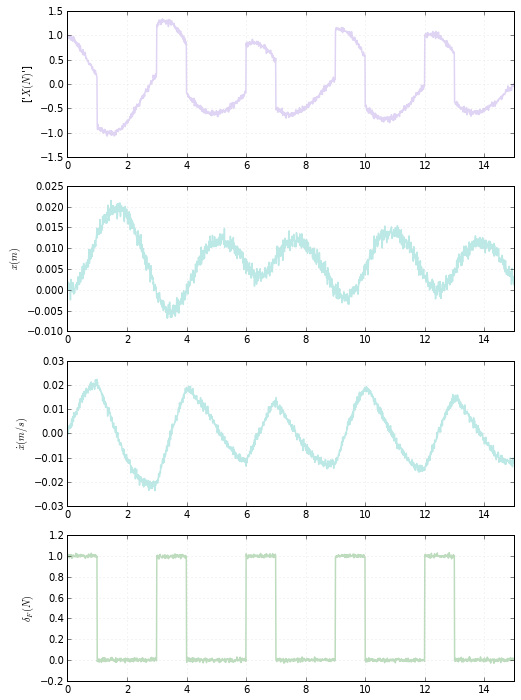

In [68]:
Axes, Lines = plot(msd.name, T, E, Z, G)

### Least-Squares Estimation

Perform a Least-Squares estimation on the measured system.

In [69]:
c_idx = ['k', 'b', 'd']

msd_est = MSD("Mass-Spring-Damper_ESTIMATED")

A = np.c_[Z[:,0],Zdot[:,0],E[:,0]]

# Least squares solution
( C, resid, rank, sigma ) = linalg.lstsq(A, G)

sigma2 = np.sum((G - np.dot(A, C))**2.0)/(N - len(c_idx)) # RMSE

cov = sigma2*np.linalg.inv(np.dot(A.T, A)) # covariance matrix
se = np.sqrt(np.diag(cov)) # standard error

alpha = 0.05
conf = 100.0*(1.0 - alpha) # confidence level

sT = stats.distributions.t.ppf(1.0 - alpha/2.0, N - len(c_idx)) # student T multiplier
CI = sT*se

SS_tot = np.sum((G - np.mean(G))**2.0)
SS_err = np.sum((np.dot(A, C) - G)**2)

#  http://en.wikipedia.org/wiki/Coefficient_of_determination
Rsq = 1.0 - SS_err/SS_tot

print "            TRUE       EST    %2.0f%% CONF" % conf
for i in range(len(c_idx)):
    print "%5s: %10.4f %10.4f +/-%-.4f" % (c_idx[i], msd.C[c_idx[i]], C[i], CI[i])

print "R^2 = %.4f" % Rsq

for i in range(len(c_idx)):
    msd_est.C[c_idx[i]] = np.ravel(C)[i]

# Estimated force matrix
H = np.dot(A, C)

# Function to interpolate over control input at integration time
e_func = interpolate.interp1d(T, E, kind='linear', axis=0, bounds_error=False)

# Compute the response
Xe, Xedot, Fe = msd_est.integrate(z0, T, e_func)

            TRUE       EST    95% CONF
    k:   -50.0000   -49.6254 +/-0.3224
    b:   -10.0000    -9.9205 +/-0.2738
    d:     1.0000     0.9988 +/-0.0053
R^2 = 0.9930


That's pretty good. Let's see how the estimated system response compares.

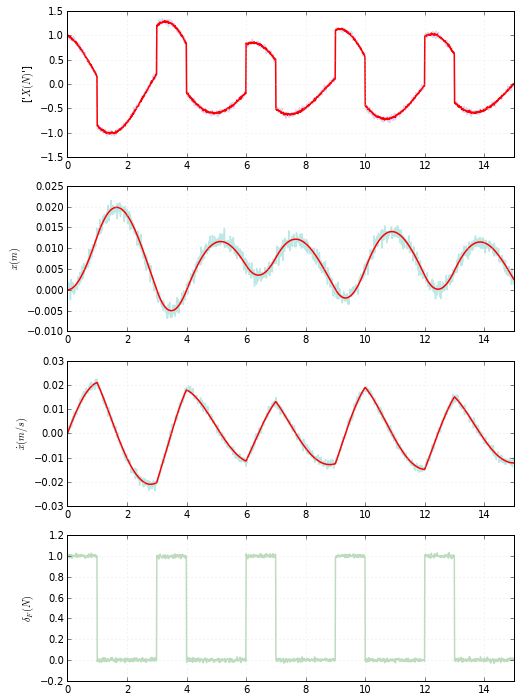

In [70]:
Axes, Lines = plot(msd.name, T, E, Z, G, Xe, Fe)

Nice. Ok, now let's increase the amount of noise on the state & state rate by 10.

In [71]:
if ADD_NOISE:
    sdz = np.array([ 0.1, 0.1 ])*0.1
    Z = X + np.random.randn(N, len(x0))*sdz

    sdzdot = np.array([ 0.1, 0.1 ])*0.1
    Zdot = Xdot + np.random.randn(N, len(x0))*sdzdot

for n in range(N):
    G[n] = msd.forces(Zdot[n], Z[n])
sdg = np.std(F - G)

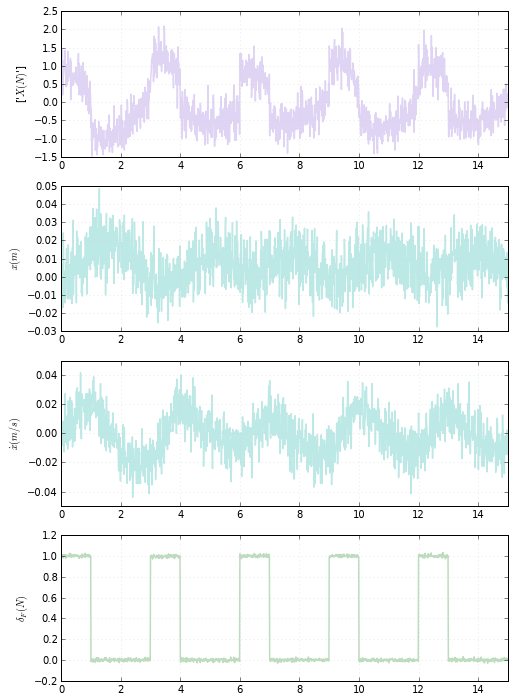

In [72]:
Axes, Lines = plot(msd.name, T, E, Z, G)

And perform a Least-Squares estimation again. The code here is exactly the same as above.

In [73]:
A = np.c_[Z[:,0],Zdot[:,0],E[:,0]]

# Least squares solution
( C, resid, rank, sigma ) = linalg.lstsq(A, G)

sigma2 = np.sum((G - np.dot(A, C))**2.0)/(N - len(c_idx)) # RMSE

cov = sigma2*np.linalg.inv(np.dot(A.T, A)) # covariance matrix
se = np.sqrt(np.diag(cov)) # standard error

alpha = 0.05
conf = 100.0*(1.0 - alpha) # confidence level

sT = stats.distributions.t.ppf(1.0 - alpha/2.0, N - len(c_idx)) # student T multiplier
CI = sT*se

SS_tot = np.sum((G - np.mean(G))**2.0)
SS_err = np.sum((np.dot(A, C) - G)**2)

#  http://en.wikipedia.org/wiki/Coefficient_of_determination
Rsq = 1.0 - SS_err/SS_tot

print "            TRUE       EST    %2.0f%% CONF" % conf
for i in range(len(c_idx)):
    print "%5s: %10.4f %10.4f +/-%-.4f" % (c_idx[i], msd.C[c_idx[i]], C[i], CI[i])

print "R^2 = %.4f" % Rsq

for i in range(len(c_idx)):
    msd_est.C[c_idx[i]] = np.ravel(C)[i]

# Estimated force matrix
H = np.dot(A, C)

# Compute the response
Xe, Xedot, Fe = msd_est.integrate(z0, T, e_func)

            TRUE       EST    95% CONF
    k:   -50.0000   -22.8983 +/-1.7733
    b:   -10.0000    -4.2307 +/-1.5904
    d:     1.0000     0.9205 +/-0.0411
R^2 = 0.6149


Whoa! That's terrible! How does the regression look?

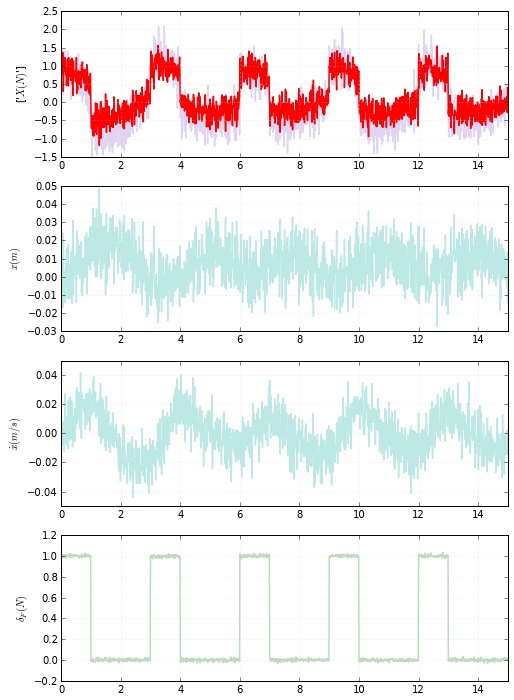

In [74]:
Axes, Lines = plot(msd.name, T, E, Z, G, Xe=None, Fe=np.dot(A, C))

Not great. And the estimated system response?

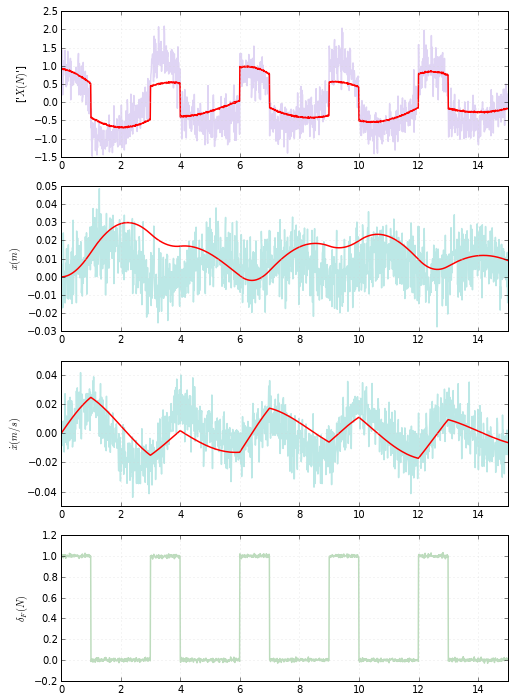

In [75]:
Axes, Lines = plot(msd.name, T, E, Z, G, Xe, Fe)

Hopeless! This is primarily due to the fact that the error in the independant variables is introducing bias into the LS estimate.

### Nonlinear (iterative) Gradient-based Estimation

Let's try that again, this time using an iterative technique. We'll use Powell's Method here.

In [62]:
msd_fest = MSD("Mass-Spring-Damper_FMIN_EST")

def objfun(x):
    for i in range(len(c_idx)):
        msd_fest.C[c_idx[i]] = x[i]

    # Compute the response
    Xe, Xedot, Fe = msd_fest.integrate(z0, T, e_func)

    # For fmin, fmin_powell, fmin_bfgs, fmin_l_bfgs_b
    dF = F - Fe
    fopt = np.sum(dF*dF)
    sys.stdout.write("[")
    for i in range(len(c_idx)):
        sys.stdout.write(" %s: %.4f" % (c_idx[i], x[i]))
    sys.stdout.write("] fopt = %.6e\n" % fopt)
    sys.stdout.flush()
    return fopt

# Need to start with a nontrivial parameter set to avoid getting stuck in a local minima straight away...
C = optimize.fmin_powell(objfun, C0)
C = C.reshape((-1, 1))

print
print "            TRUE      F_EST"
for i in range(len(c_idx)):
    print "%5s: %10.4f %10.4f" % (c_idx[i], msd.C[c_idx[i]], np.ravel(C)[i])

for i in range(len(c_idx)):
    msd_fest.C[c_idx[i]] = np.ravel(C)[i]

# Compute the response
Xe, Xedot, Fe = msd_fest.integrate(z0, T, e_func)

[ k: -5.0000 b: -1.0000 d: 0.1000] fopt = 6.347409e+02
[ k: -5.0000 b: -1.0000 d: 0.1000] fopt = 6.347409e+02
[ k: -4.0000 b: -1.0000 d: 0.1000] fopt = 6.348958e+02
[ k: -6.6180 b: -1.0000 d: 0.1000] fopt = 6.329532e+02
[ k: -9.2361 b: -1.0000 d: 0.1000] fopt = 6.289290e+02
[ k: -13.4721 b: -1.0000 d: 0.1000] fopt = 6.265655e+02
[ k: -13.3070 b: -1.0000 d: 0.1000] fopt = 6.265661e+02
[ k: -20.3262 b: -1.0000 d: 0.1000] fopt = 6.253840e+02
[ k: -19.3783 b: -1.0000 d: 0.1000] fopt = 6.260965e+02
[ k: -31.4164 b: -1.0000 d: 0.1000] fopt = 6.089231e+02
[ k: -49.3607 b: -1.0000 d: 0.1000] fopt = 5.807445e+02
[ k: -78.3951 b: -1.0000 d: 0.1000] fopt = 5.512612e+02
[ k: -106.8643 b: -1.0000 d: 0.1000] fopt = 3.988342e+02
[ k: -152.9285 b: -1.0000 d: 0.1000] fopt = 1.033998e+03
[ k: -106.8643 b: -1.0000 d: 0.1000] fopt = 3.988342e+02
[ k: -124.4593 b: -1.0000 d: 0.1000] fopt = 5.525858e+02
[ k: -95.9901 b: -1.0000 d: 0.1000] fopt = 4.540821e+02
[ k: -105.8457 b: -1.0000 d: 0.1000] fopt = 4.005

Much better! Although it did take some time. And the system response is quite good too.

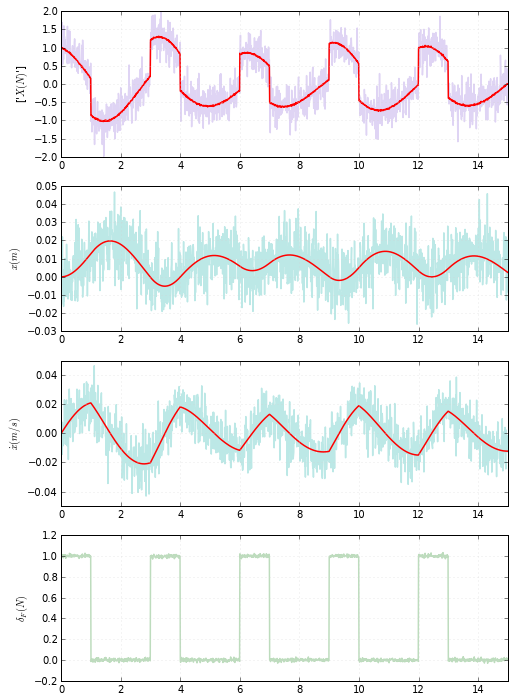

In [63]:
Axes, Lines = plot(msd.name, T, E, Z, G, Xe, Fe)

Other methods (from the SciPy Optimisation Library) that work just as well include BFGS, and nonlinear Least-Squares.